In [1]:
import pandas as pd
import numpy as np
from tsfeatures import tsfeatures, acf_features, stl_features, statistics
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff
from pmdarima import auto_arima, ARIMA
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import jarque_bera as jb
from prophet import Prophet

%matplotlib inline

In [2]:
data = pd.read_csv('data/superstore.csv', encoding = "ISO-8859-1")
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
data['Order Date'] = pd.to_datetime(data['Order Date'])
monthly_sales = data.groupby([pd.Grouper(key='Order Date', freq='M'), 'Category'])['Sales'].sum()
monthly_sales.head()

Order Date  Category       
2014-01-31  Furniture          6242.525
            Office Supplies    4851.080
            Technology         3143.290
2014-02-28  Furniture          1839.658
            Office Supplies    1071.724
Name: Sales, dtype: float64

In [4]:
features = pd.DataFrame(monthly_sales.copy())
features.reset_index(inplace=True)
features.head()

,Order Date,Category,Sales
0,2014-01-31,Furniture,6242.525
1,2014-01-31,Office Supplies,4851.080
2,2014-01-31,Technology,3143.290
3,2014-02-28,Furniture,1839.658
4,2014-02-28,Office Supplies,1071.724


In [5]:
features.rename(columns={'Order Date': 'ds', 'Sales': 'y', 'Category': 'unique_id'}, inplace=True)
features.head()

,ds,unique_id,y
0,2014-01-31,Furniture,6242.525
1,2014-01-31,Office Supplies,4851.080
2,2014-01-31,Technology,3143.290
3,2014-02-28,Furniture,1839.658
4,2014-02-28,Office Supplies,1071.724


In [6]:
tsfeatures(features, freq=30, features=[acf_features])

,unique_id,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Furniture,0.296613,0.248431,-0.401140,0.482436,-0.587269,0.720740,-0.067398
1,Office Supplies,0.346595,0.273683,-0.419869,0.467545,-0.580794,0.646733,-0.081835
2,Technology,0.209677,0.084553,-0.431491,0.373567,-0.596151,0.660406,-0.031988


In [7]:
tsfeatures(features, freq=30, features=[stl_features])

,unique_id,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough
0,Furniture,1,30,1,7.625542e-66,2.635851,-4.718448e-16,0.045461,0.197753,1,6,7
1,Office Supplies,1,30,1,7.541486e-66,3.272922,-5.551115e-16,0.158533,0.278774,1,6,8
2,Technology,1,30,1,1.022913e-65,2.961985,-3.885781e-16,-0.221408,0.359216,1,17,8


In [8]:
tsfeatures(features, freq=30, features=[statistics])

,unique_id,total_sum,mean,variance,median,p2point5,p5,p25,p75,p95,p97point5,max,min
0,Furniture,1.776357e-15,3.700743e-17,1.0,-0.308431,-1.338507,-1.188439,-0.676709,0.679534,1.778778,2.236840,2.372458,-1.495932
1,Office Supplies,1.731948e-14,3.608225e-16,1.0,-0.232597,-1.482923,-1.196267,-0.713474,0.541197,1.889071,1.972432,2.695727,-1.628910
2,Technology,-2.220446e-15,-4.625929e-17,1.0,-0.212104,-1.363632,-1.299979,-0.744524,0.571026,1.515604,1.709112,3.115816,-1.515907


In [9]:
sales_df = pd.DataFrame(monthly_sales).reset_index()
sales_df.head()

,Order Date,Category,Sales
0,2014-01-31,Furniture,6242.525
1,2014-01-31,Office Supplies,4851.080
2,2014-01-31,Technology,3143.290
3,2014-02-28,Furniture,1839.658
4,2014-02-28,Office Supplies,1071.724


In [10]:
pd.crosstab(sales_df['Order Date'].dt.year, sales_df['Order Date'].dt.quarter)

Order Date,1,2,3,4
Order Date,,,,
2014,9,9,9,9
2015,9,9,9,9
2016,9,9,9,9
2017,9,9,9,9


In [11]:
monthly_all_df = sales_df.pivot_table(index='Order Date', values='Sales', aggfunc='sum')
monthly_all_df.head()

,Sales
Order Date,
2014-01-31,14236.895
2014-02-28,4519.892
2014-03-31,55691.009
2014-04-30,28295.345
2014-05-31,23648.287


In [12]:
train_chart = alt.Chart(monthly_all_df.reset_index()).mark_line(point=True).encode(
    x = 'Order Date',
    y = 'Sales',
    #color = 'Category',
    tooltip = ['Order Date', 'Sales']
)

rolling_mean = alt.Chart(sales_df.reset_index()).mark_trail(
    color = 'red',
    size = 1
).transform_window(
    rolling_mean = 'mean(Sales)'
).encode(
    x = 'Date:T',
    y = 'rolling_mean:Q',
    size = 'Sales'
)

scales = alt.selection_interval(bind='scales')

(train_chart + rolling_mean).properties(
    width = 600,
    title = 'Sales of French Retail').add_selection(scales
)

alt.LayerChart(...)

In [13]:
alt.Chart(monthly_all_df.reset_index()).mark_line(point=True).encode(
    x = 'quarter(Order Date)',
    y = 'Sales',
    column = 'year(Order Date)',
    tooltip = ['Order Date', 'Sales']
).properties(
    width = 100,
    title = 'yearly subseries plot'
)

alt.Chart(...)

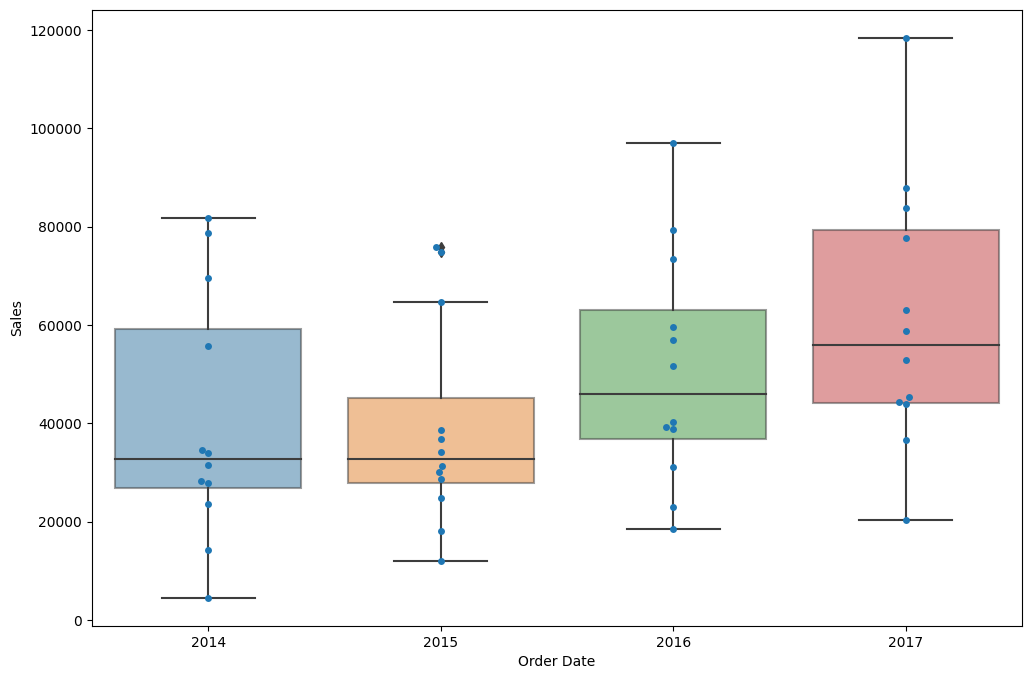

In [14]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.boxplot(data = monthly_all_df, x = monthly_all_df.index.year, y = 'Sales', ax = ax, boxprops = dict(alpha = .5))
sns.swarmplot(data = monthly_all_df, x = monthly_all_df.index.year, y = 'Sales');

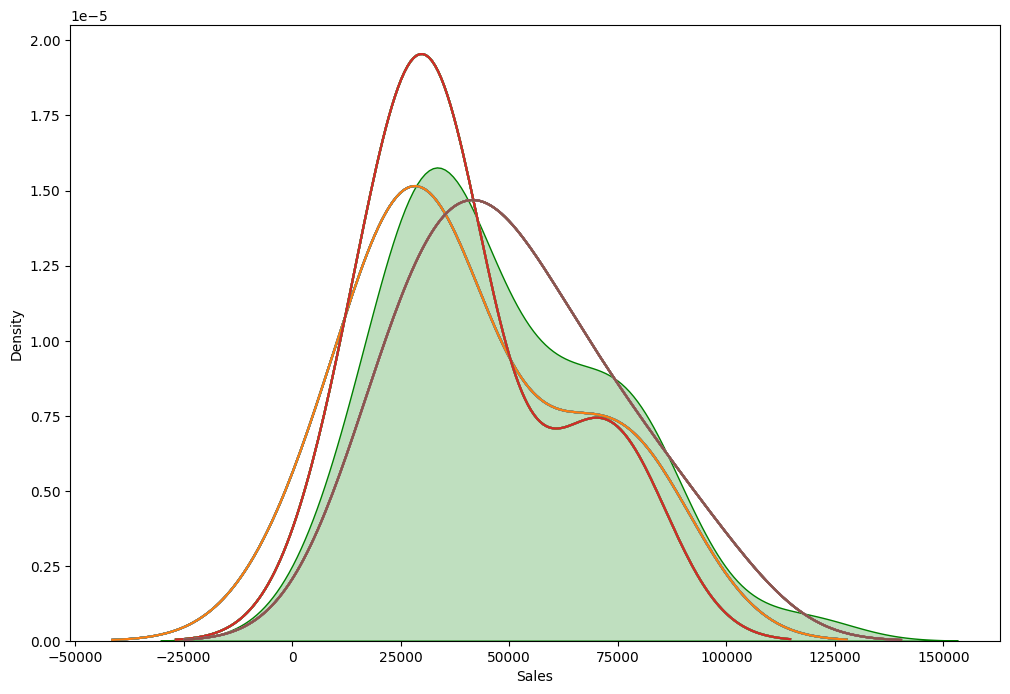

In [15]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.kdeplot(
    data = monthly_all_df,
    x = 'Sales',
    #hue = train.index.year,
    fill = True,
    color = 'green',
    label = 'Sales',
    ax = ax,
    legend = True
)

for year in monthly_all_df.index.year.values:
    if year == 2017:
        break
    sns.kdeplot(
        data = monthly_all_df[monthly_all_df.index.year == year],
        x = 'Sales',
        ax = ax,
        label = f'{year}',
        legend = True
    )

In [16]:
stack1 = alt.Chart(monthly_all_df.reset_index()).mark_bar().encode(
    x = alt.X('sum(Sales)'),
    y = 'year(Order Date):N',
    color = alt.Color(
        'quarter(Order Date)',
        scale = alt.Scale(scheme='category10')
    ),
    tooltip = ['Order Date', 'Sales']
).properties(
    width = 300,
    height = 100,
    title = 'Sum of Sales by quarter'
)

stack2 = alt.Chart(monthly_all_df.reset_index()).mark_bar().encode(
    x = alt.X('sum(Sales)', stack = 'normalize'),
    y = 'year(Order Date):N',
    color = alt.Color(
        'quarter(Order Date)',
        scale = alt.Scale(scheme='category10')
    ),
    tooltip = ['Order Date', 'Sales']
).properties(
    width = 300,
    height = 100,
    title = 'Sum of Sales as % by quarter'
)


stack1 | stack2

alt.HConcatChart(...)

In [17]:
train_2017 = monthly_all_df
avg_2017 = int(monthly_all_df['Sales'].mean())

qrt_avg = train_2017.groupby(train_2017.index.quarter)['Sales'].mean()
qrt_table = pd.pivot_table(train_2017, index = train_2017.index.quarter, columns = train_2017.index.year)

qrt_table['avg'] = qrt_avg
qrt_table['additive'] = qrt_table['avg'] - avg_2017
qrt_table['multiplicative'] = (qrt_table['avg'] / avg_2017).round(2)

qrt_table.index.name = 'Quarters'

qrt_table

Sales                                            \
Order Date          2014          2015          2016          2017   
Quarters                                                             
1           24815.932000  22950.579533  31079.060333  41048.286733   
2           28846.253200  29708.062333  45360.767000  44588.124000   
3           47877.737433  43419.858400  47929.120733  65417.318667   
4           59875.910067  60765.669400  78699.584600  93351.355667   

                     avg      additive multiplicative  
Order Date                                             
Quarters                                               
1           29973.464650 -17884.535350           0.63  
2           37125.801633 -10732.198367           0.78  
3           51161.008808   3303.008808           1.07  
4           73173.129933  25315.129933           1.53

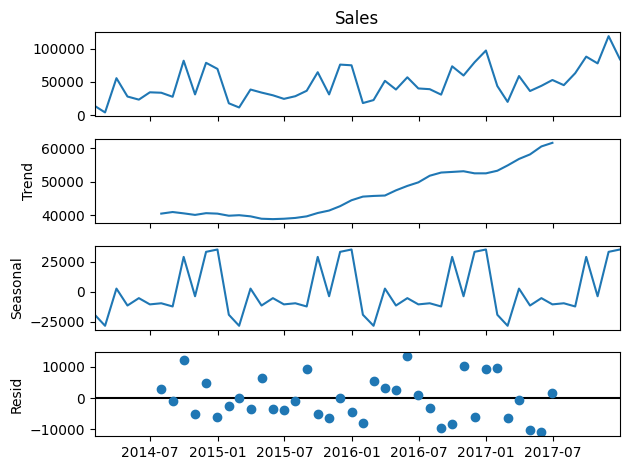

In [18]:
decompose = seasonal_decompose(monthly_all_df['Sales'])
decompose.plot();
plt.rcParams['figure.figsize'] = (12, 8)

In [19]:
ljung(decompose.resid.dropna(), return_df=True)

,lb_stat,lb_pvalue
1,0.092960,0.760447
2,0.098686,0.951855
3,0.151658,0.984988
4,8.137157,0.086681
5,8.844191,0.115443
6,9.242472,0.160394
7,10.360589,0.169043


47858.35125625


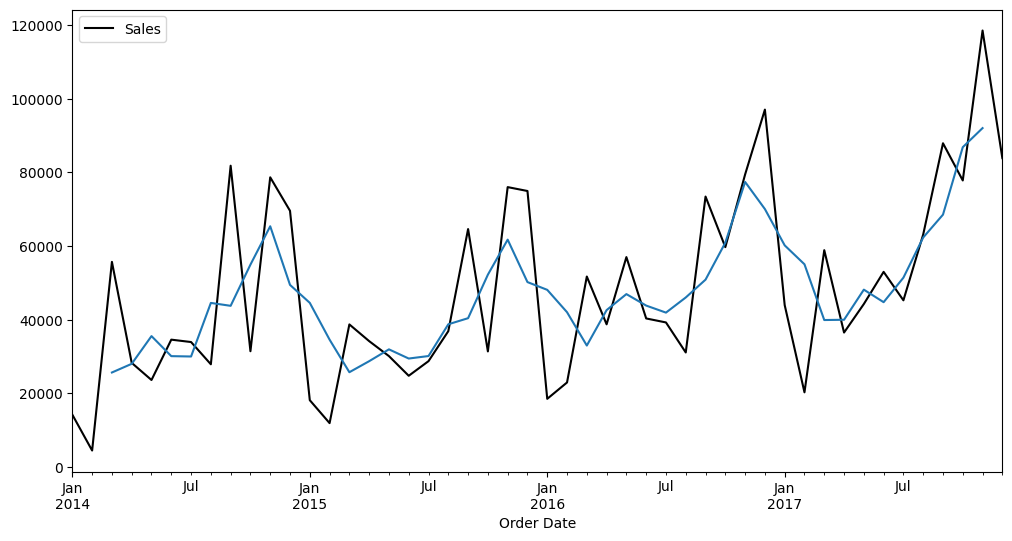

In [20]:
monthly_all_df.plot(figsize = (12,6), legend = True, label = 'Train', cmap = 'gray')
monthly_all_df['Sales'].rolling(4, center = True).mean().plot(label = 'Rolling Mean 4Q');
print(monthly_all_df['Sales'].mean())

In [21]:
train = monthly_all_df.iloc[:-6]
test = monthly_all_df.iloc[-6:]

horizon = 6
train_length = len(train)

predictions = test.copy()

train_bcox, bcox_lam = boxcox(train['Sales'])
test_bcox = boxcox(test['Sales'], lmbda=bcox_lam)
train_log = np.log(train['Sales'])

In [22]:
def pysnaive(train_series, seasonal_periods, forecast_horizon):
    if len(train_series) >= seasonal_periods:
        last_season = train_series.iloc[-seasonal_periods:]
        reps = int(np.ceil(forecast_horizon/seasonal_periods))
        fcarray = np.tile(last_season, reps=reps)
        fcast = pd.Series(fcarray[:forecast_horizon])
        fitted = train_series.shift(seasonal_periods)
    return fitted, fcast


py_snaive_fit, py_snaive = pysnaive(train['Sales'], 4, 6)
residuals = (train['Sales'] - py_snaive_fit).dropna()
predictions['py_snaive'] = py_snaive.values

predictions

,Sales,py_snaive
Order Date,,
2017-07-31,45264.4160,58872.3528
2017-08-31,63120.8880,36521.5361
2017-09-30,87866.6520,44261.1102
2017-10-31,77776.9232,52981.7257
2017-11-30,118447.8250,58872.3528
2017-12-31,83829.3188,36521.5361


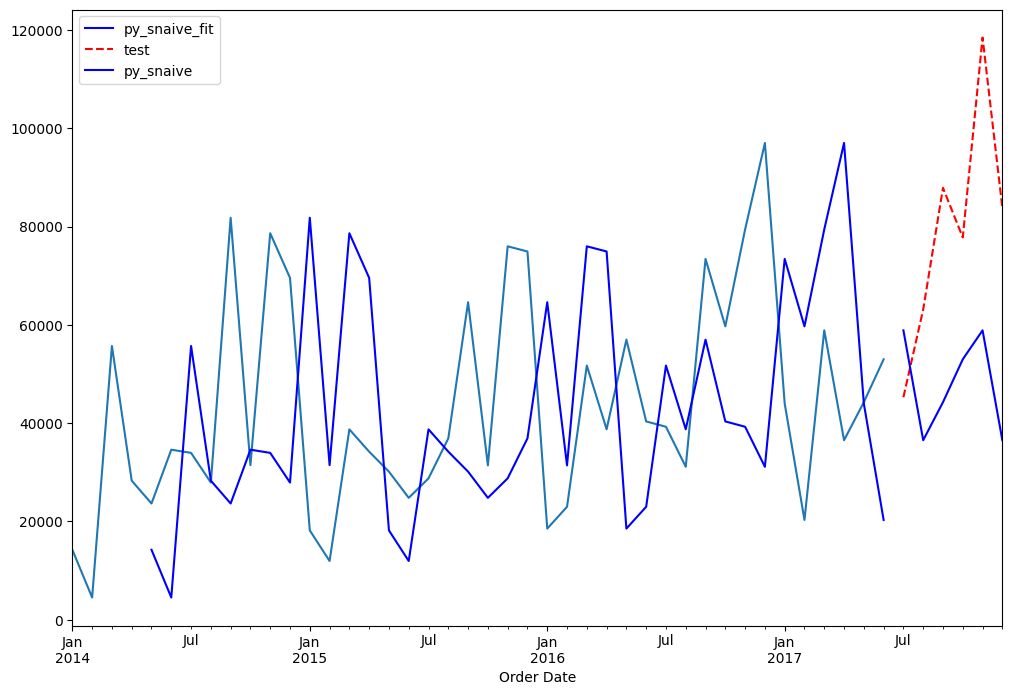

In [23]:
train['Sales'].plot(figsize=(12,8))
py_snaive_fit.plot(color = 'b', legend=True, label='py_snaive_fit')
predictions['Sales'].plot(style='--', color = 'r', legend=True, label='test')
predictions['py_snaive'].plot(color = 'b', legend=True, label='py_snaive');

In [24]:
def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
    
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
    
    Lags should be min(2*seasonal_period, T/5)
    
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
    
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(ljung(x=residuals, lags=lags).iloc[:,1])
    norm_p_val =  jb(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
    
    
    
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", np.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3), "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    
    
    return ts_ax, acf_ax, kde_ax

def accuracy(y1,y2):    
    rms_error = np.round(rmse(y1, y2),1)
    
    map_error = np.round(np.mean(np.abs((np.array(y1) - np.array(y2)) / np.array(y1))) * 100,1)
           
    accuracy_df=pd.DataFrame({"RMSE":[rms_error], "%MAPE": [map_error]})
    
    return accuracy_df

In [25]:
accuracy(predictions['Sales'], predictions['py_snaive'])

,RMSE,%MAPE
0,39149.7,43.4


** Mean of the residuals:  2365.62

** Ljung Box Test, p-value: 0.113 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.562 (>0.05, Normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


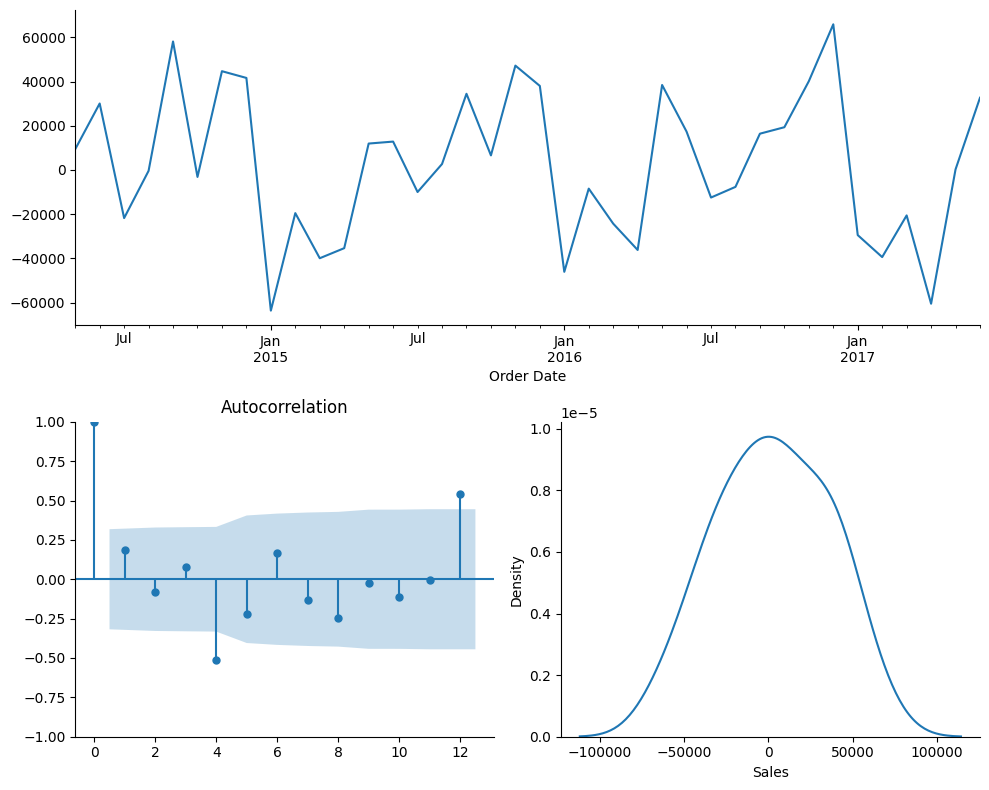

In [26]:
residcheck(residuals.dropna(), 12);

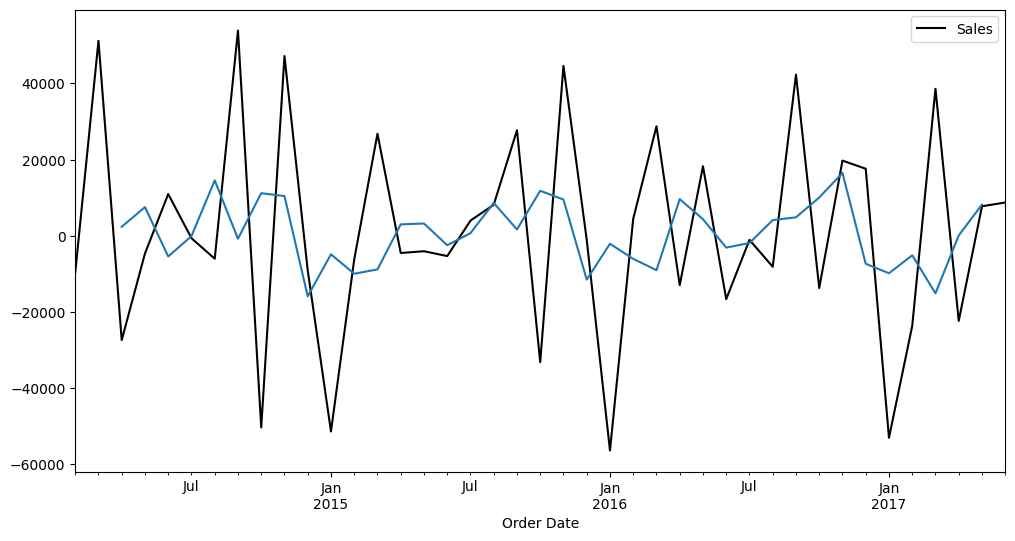

In [27]:
de_trended = train.diff(1).dropna()
de_trended.plot(figsize = (12,6), legend = True, label = 'Train', cmap = 'gray')
de_trended['Sales'].rolling(4, center = True).mean().plot(label = 'Rolling Mean 4Q');

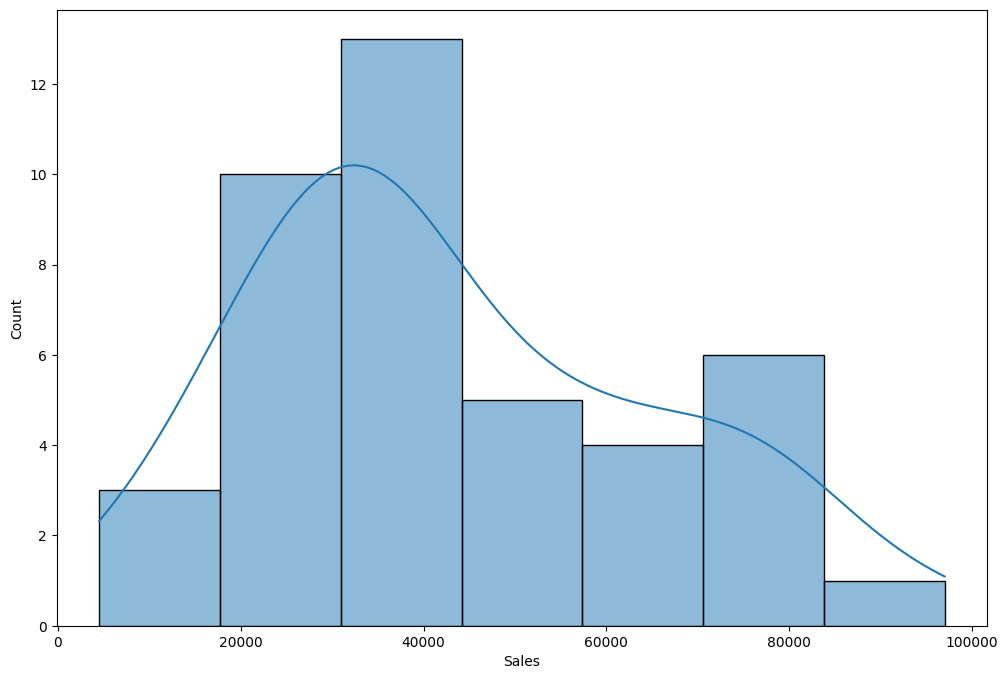

In [28]:
sns.histplot(train, x = 'Sales', kde = True);

In [29]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, HoltWinters, SeasonalNaive, HistoricAverage

In [39]:
nixtla_df = monthly_all_df.reset_index()
nixtla_df.rename(columns = {'Order Date': 'ds', 'Sales': 'y'}, inplace = True)
nixtla_df['unique_id'] = 'all'
test = nixtla_df.iloc[-6:]
train = nixtla_df.iloc[:-6]
nixtla_df.head()

,ds,y,unique_id
0,2014-01-31,14236.895,all
1,2014-02-28,4519.892,all
2,2014-03-31,55691.009,all
3,2014-04-30,28295.345,all
4,2014-05-31,23648.287,all


In [61]:
models = [AutoETS(season_length=12)]
sf_ETS = StatsForecast(models = models, freq='M')
sf_ETS.fit(train)

StatsForecast(models=[AutoETS])

In [62]:
forecast_df = sf_ETS.forecast(df=train, level= [90], h = 6)
forecast_df

,ds,AutoETS,AutoETS-lo-90,AutoETS-hi-90
unique_id,,,,
all,2017-07-31,43986.093750,28107.505859,59864.679688
all,2017-08-31,40872.316406,24659.078125,57085.558594
all,2017-09-30,81991.382812,65450.257812,98532.500000
all,2017-10-31,49274.417969,32411.787109,66137.054688
all,2017-11-30,84976.328125,67798.203125,102154.453125
all,2017-12-31,87223.507812,69735.578125,104711.429688


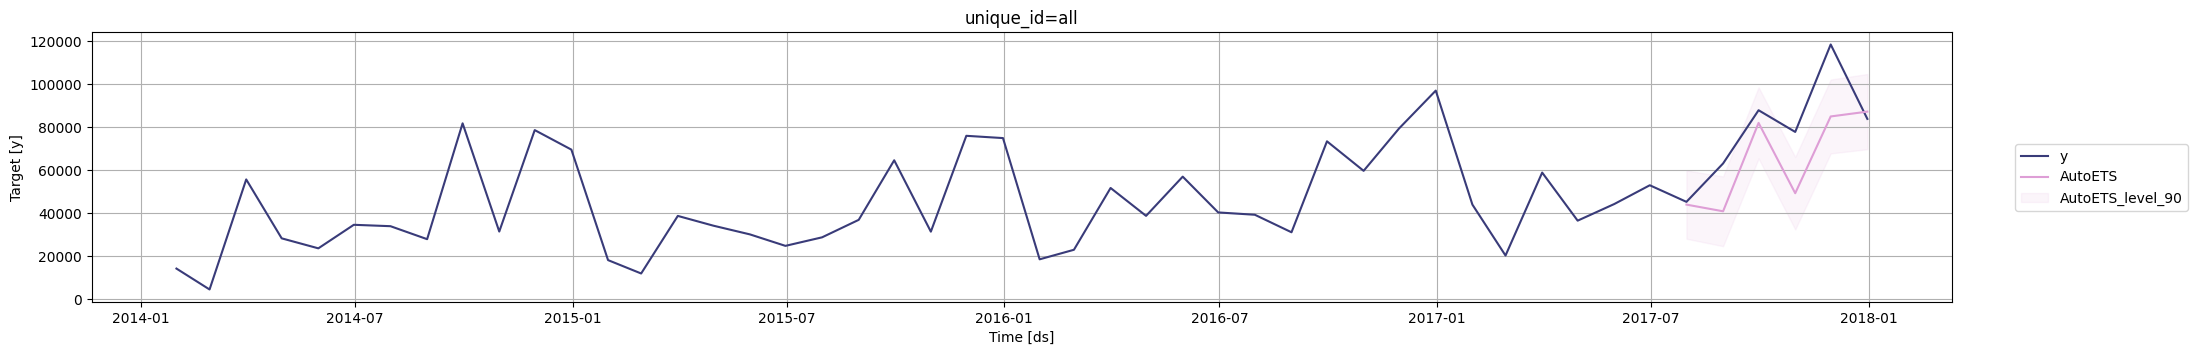

In [63]:
sf_ETS.plot(nixtla_df, forecast_df, level=[90])

In [64]:
models = [AutoARIMA(season_length=12)]
sf_ARIMA = StatsForecast(models = models, freq='M')
sf_ARIMA.fit(train)

StatsForecast(models=[AutoARIMA])

In [65]:
forecast_df = sf_ARIMA.forecast(df=train, level= [90], h = 6)
forecast_df

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
all,2017-07-31,39261.964844,18463.466797,60060.457031
all,2017-08-31,31115.375000,10316.878906,51913.871094
all,2017-09-30,73410.023438,52611.527344,94208.523438
all,2017-10-31,59687.746094,38889.250000,80486.242188
all,2017-11-30,79411.968750,58613.468750,100210.460938
all,2017-12-31,96999.046875,76200.546875,117797.539062


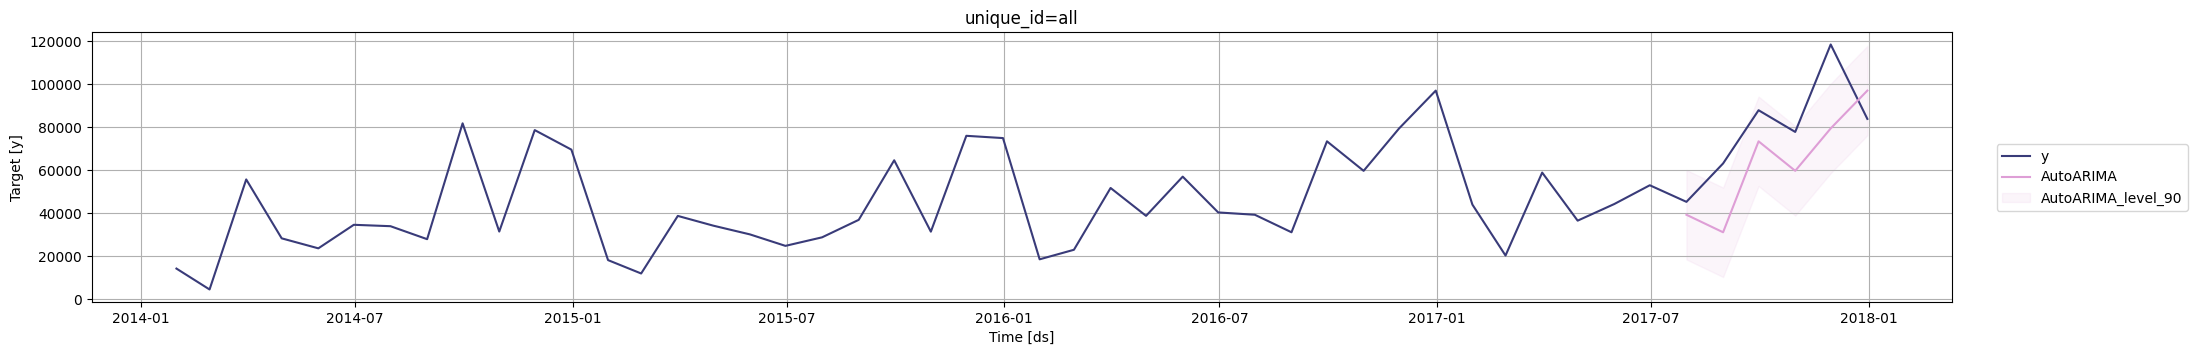

In [66]:
sf_ARIMA.plot(nixtla_df, forecast_df, level=[90])

In [82]:
models = [
    HoltWinters(),
    SeasonalNaive(season_length=12),
    HistoricAverage(),
    AutoARIMA(season_length=12), 
    AutoETS(season_length=12)]
sf_all = StatsForecast(models = models, freq='M', fallback_model=SeasonalNaive(season_length=7))
sf_all.fit(train)

StatsForecast(models=[HoltWinters,SeasonalNaive,HistoricAverage,AutoARIMA,AutoETS])

In [90]:
forecast_df = sf_all.forecast(df=train, level= [90], h = 6)
forecast_df


,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90
unique_id,,,,,,,,,,,,,,,,
all,2017-07-31,96999.046875,41656.007812,152342.093750,39261.964844,18463.527344,60060.402344,43354.640625,6620.78125,80088.5,39261.964844,18463.466797,60060.457031,43986.093750,28107.505859,59864.679688
all,2017-08-31,43971.375000,-11371.665039,99314.414062,31115.375000,10316.936523,51913.812500,43354.640625,6620.78125,80088.5,31115.375000,10316.878906,51913.871094,40872.316406,24659.078125,57085.558594
all,2017-09-30,20301.132812,-35041.906250,75644.171875,73410.023438,52611.585938,94208.460938,43354.640625,6620.78125,80088.5,73410.023438,52611.527344,94208.523438,81991.382812,65450.257812,98532.500000
all,2017-10-31,58872.351562,3529.311523,114215.390625,59687.746094,38889.308594,80486.187500,43354.640625,6620.78125,80088.5,59687.746094,38889.250000,80486.242188,49274.417969,32411.787109,66137.054688
all,2017-11-30,36521.535156,-18821.505859,91864.578125,79411.968750,58613.531250,100210.406250,43354.640625,6620.78125,80088.5,79411.968750,58613.468750,100210.460938,84976.328125,67798.203125,102154.453125
all,2017-12-31,44261.109375,-11081.930664,99604.148438,96999.046875,76200.609375,117797.484375,43354.640625,6620.78125,80088.5,96999.046875,76200.546875,117797.539062,87223.507812,69735.578125,104711.429688


In [3]:
sf_all.plot(nixtla_df, forecast_df, level=[90])

NameError: name 'sf_all' is not defined

In [88]:
crossvalidation_df = sf_all.cross_validation(
    df=nixtla_df,
    h=6,
    step_size=6,
    n_windows=2
)
crossvalidation_df

,ds,cutoff,y,HoltWinters,SeasonalNaive,HistoricAverage,AutoARIMA,AutoETS
unique_id,,,,,,,,
all,2017-01-31,2016-12-31,43971.375000,40344.535156,18542.490234,43444.042969,31049.412109,32197.599609
all,2017-02-28,2016-12-31,20301.132812,39261.964844,22978.814453,43444.042969,35485.734375,26307.500000
all,2017-03-31,2016-12-31,58872.351562,31115.375000,51715.875000,43444.042969,64222.796875,61492.648438
all,2017-04-30,2016-12-31,36521.535156,73410.023438,38750.039062,43444.042969,51256.960938,44929.003906
all,2017-05-31,2016-12-31,44261.109375,59687.746094,56987.726562,43444.042969,69494.648438,53643.816406
all,2017-06-30,2016-12-31,52981.726562,79411.968750,40344.535156,43444.042969,52851.453125,46007.710938
all,2017-07-31,2017-06-30,45264.414062,96999.046875,39261.964844,43354.640625,39261.964844,43986.093750
all,2017-08-31,2017-06-30,63120.886719,43971.375000,31115.375000,43354.640625,31115.375000,40872.316406
all,2017-09-30,2017-06-30,87866.648438,20301.132812,73410.023438,43354.640625,73410.023438,81991.382812


In [87]:
crossvalidation_df.reset_index().drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    df = df.reset_index()
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

evaluation_df = evaluate_cross_validation(crossvalidation_df, mse)
evaluation_df

,HoltWinters,SeasonalNaive,HistoricAverage,AutoARIMA,AutoETS,best_model
unique_id,,,,,,
all,1.640303e+09,360456608.0,979267584.0,381157696.0,238694000.0,AutoETS
